## Applying cubic spline to interpolate the Brazilian Yield Curve

#### Thais Palanca - 53243

#### Importing all necessary packages

In [219]:
import pandas as pd
import numpy as np
from dataapi import DBConnect, SGS 
import sgs
import matplotlib.pyplot as plt
from calendars import DayCounts #Thanks to Insper Finance HUB
from tqdm import tqdm
%matplotlib inline

#### This data comes from R, it contains all commodities in B3, we need to filter it to get only DI1

In [3]:
df = pd.read_csv("df.csv")
df_di1 = df[df['commodity'] == 'DI1']
df_di1.head(10)

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value
47,48,2001-01-02,DI1,JAN1,DI1JAN1,100000.11,100000.00,-0.11,0.11
48,49,2001-01-02,DI1,FEV1,DI1FEV1,98734.34,98735.00,0.66,0.66
49,50,2001-01-02,DI1,MAR1,DI1MAR1,97703.15,97701.00,-2.15,2.15
50,51,2001-01-02,DI1,ABR1,DI1ABR1,96451.70,96446.54,-5.16,5.16
51,52,2001-01-02,DI1,MAI1,DI1MAI1,95320.00,95299.00,-21.00,21.00
52,53,2001-01-02,DI1,JUL1,DI1JUL1,92899.00,92878.16,-20.84,20.84
53,54,2001-01-02,DI1,OUT1,DI1OUT1,89253.36,89215.00,-38.36,38.36
54,55,2001-01-02,DI1,NOV1,DI1NOV1,88011.92,87985.00,-26.92,26.92
55,56,2001-01-02,DI1,JAN2,DI1JAN2,85819.38,85790.00,-29.38,29.38
56,57,2001-01-02,DI1,ABR2,DI1ABR2,82585.64,82565.00,-20.64,20.64


#### There was a change in the maturity code in between the time series, we need to correct it 

In [220]:
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(JAN)(\d+)', value='F\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(FEV)(\d+)', value='G\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(MAR)(\d+)', value='H\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(ABR)(\d+)', value='J\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(MAI)(\d+)', value='K\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(JUN)(\d+)', value='M\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(JUL)(\d+)', value='N\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(AGO)(\d+)', value='Q\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(SET)(\d+)', value='U\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(OUT)(\d+)', value='V\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(NOV)(\d+)', value='X\\2', regex=True)
df_di1.loc[:, 'maturity_code'] = df_di1['maturity_code'].replace(to_replace='^(DEZ)(\d+)', value='Z\\2', regex=True)
df_di1.head(3)

#I was not able to do a loop, but I managed to make it work

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value,maturity_date,DU,settlement_rate
47,48,2001-01-02,DI1,F1,DI1JAN1,100000.11,100000.0,-0.11,0.11,2001-01-02,0,0.000000
48,49,2001-01-02,DI1,G1,DI1FEV1,98734.34,98735.0,0.66,0.66,2001-02-01,22,0.156993
49,50,2001-01-02,DI1,H1,DI1MAR1,97703.15,97701.0,-2.15,2.15,2001-03-01,40,0.157807


#### Compute the business days until maturity

In [5]:
mat_dict = {'01': 'F',
            '02': 'G',
            '03': 'H',
            '04': 'J',
            '05': 'K',
            '06': 'M',
            '07': 'N',
            '08': 'Q',
            '09': 'U',
            '10': 'V',
            '11': 'X',
            '12': 'Z'}

mat_dict = {v: k for k, v in mat_dict.items()}

mat_month = df_di1['maturity_code'].str[0].map(mat_dict)
print(mat_month)

47        01
48        02
49        03
50        04
51        05
          ..
190655    01
190656    01
190657    01
190658    01
190659    01
Name: maturity_code, Length: 28627, dtype: object


#### Change the date - recall that all DI1 contracts expire in the first business day of the month (by construction)

In [7]:
def convert_year(year_digits):
    #gets the number only
    numeric_part = ''.join(filter(str.isdigit, str(year_digits)))
    
    if len(numeric_part) == 1:
        return '200' + numeric_part
    else:
        return '20' + numeric_part

mat_year = df_di1['maturity_code'].str[-2:].apply(convert_year)

print(mat_year)

47        2001
48        2001
49        2001
50        2001
51        2001
          ... 
190655    2027
190656    2028
190657    2029
190658    2030
190659    2031
Name: maturity_code, Length: 28627, dtype: object


In [8]:
dates = pd.to_datetime(mat_year + mat_month + '01')

In [9]:
dc = DayCounts('BUS/252', calendar='anbima')
dates = dc.busdateroll(dates, 'following')
dates

DatetimeIndex(['2001-01-02', '2001-02-01', '2001-03-01', '2001-04-02',
               '2001-05-02', '2001-07-02', '2001-10-01', '2001-11-01',
               '2002-01-02', '2002-04-01',
               ...
               '2024-10-01', '2025-01-02', '2025-07-01', '2026-01-02',
               '2026-07-01', '2027-01-04', '2028-01-03', '2029-01-02',
               '2030-01-02', '2031-01-02'],
              dtype='datetime64[s]', length=28627, freq=None)

In [11]:
df_di1.loc[:, 'maturity_date'] = dates
df_di1.head(10)

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value,maturity_date
47,48,2001-01-02,DI1,F1,DI1JAN1,100000.11,100000.00,-0.11,0.11,2001-01-02
48,49,2001-01-02,DI1,G1,DI1FEV1,98734.34,98735.00,0.66,0.66,2001-02-01
49,50,2001-01-02,DI1,H1,DI1MAR1,97703.15,97701.00,-2.15,2.15,2001-03-01
50,51,2001-01-02,DI1,J1,DI1ABR1,96451.70,96446.54,-5.16,5.16,2001-04-02
51,52,2001-01-02,DI1,K1,DI1MAI1,95320.00,95299.00,-21.00,21.00,2001-05-02
52,53,2001-01-02,DI1,N1,DI1JUL1,92899.00,92878.16,-20.84,20.84,2001-07-02
53,54,2001-01-02,DI1,V1,DI1OUT1,89253.36,89215.00,-38.36,38.36,2001-10-01
54,55,2001-01-02,DI1,X1,DI1NOV1,88011.92,87985.00,-26.92,26.92,2001-11-01
55,56,2001-01-02,DI1,F2,DI1JAN2,85819.38,85790.00,-29.38,29.38,2002-01-02
56,57,2001-01-02,DI1,J2,DI1ABR2,82585.64,82565.00,-20.64,20.64,2002-04-01


In [13]:
df_di1.loc[:, 'DU'] = dc.days(df_di1['refdate'], df_di1.loc[:, 'maturity_date'])
df_di1 = df_di1[df_di1['DU'] >= 0]
df_di1.head(5)

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value,maturity_date,DU
47,48,2001-01-02,DI1,F1,DI1JAN1,100000.11,100000.00,-0.11,0.11,2001-01-02,0
48,49,2001-01-02,DI1,G1,DI1FEV1,98734.34,98735.00,0.66,0.66,2001-02-01,22
49,50,2001-01-02,DI1,H1,DI1MAR1,97703.15,97701.00,-2.15,2.15,2001-03-01,40
50,51,2001-01-02,DI1,J1,DI1ABR1,96451.70,96446.54,-5.16,5.16,2001-04-02,62
51,52,2001-01-02,DI1,K1,DI1MAI1,95320.00,95299.00,-21.00,21.00,2001-05-02,82


In [14]:
# Deletes UPs with value zero
df_di1 = df_di1[df_di1.settlement_value != 0]

df_di1.head(10)

##seems good!

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value,maturity_date,DU
47,48,2001-01-02,DI1,F1,DI1JAN1,100000.11,100000.00,-0.11,0.11,2001-01-02,0
48,49,2001-01-02,DI1,G1,DI1FEV1,98734.34,98735.00,0.66,0.66,2001-02-01,22
49,50,2001-01-02,DI1,H1,DI1MAR1,97703.15,97701.00,-2.15,2.15,2001-03-01,40
50,51,2001-01-02,DI1,J1,DI1ABR1,96451.70,96446.54,-5.16,5.16,2001-04-02,62
51,52,2001-01-02,DI1,K1,DI1MAI1,95320.00,95299.00,-21.00,21.00,2001-05-02,82
52,53,2001-01-02,DI1,N1,DI1JUL1,92899.00,92878.16,-20.84,20.84,2001-07-02,124
53,54,2001-01-02,DI1,V1,DI1OUT1,89253.36,89215.00,-38.36,38.36,2001-10-01,188
54,55,2001-01-02,DI1,X1,DI1NOV1,88011.92,87985.00,-26.92,26.92,2001-11-01,210
55,56,2001-01-02,DI1,F2,DI1JAN2,85819.38,85790.00,-29.38,29.38,2002-01-02,250
56,57,2001-01-02,DI1,J2,DI1ABR2,82585.64,82565.00,-20.64,20.64,2002-04-01,310


#### Get CDI data and make it yearly

In [17]:
sgs = SGS()
df_cdi = sgs.fetch({12: 'CDI'})/100
df_cdi.tail(5)

,CDI
data,
2023-12-08,0.000455
2023-12-11,0.000455
2023-12-12,0.000455
2023-12-13,0.000455
2023-12-14,0.000437


In [19]:
cdi_series = pd.Series(((1+df_cdi['CDI'])**(252))-1)

#### Calculate DIs Unite Price - UP

In [21]:
df_di1['settlement_rate'] = (100000/df_di1['price'])**(252/df_di1['DU'])-1 
df_di1.tail(10)

,Unnamed: 0,refdate,commodity,maturity_code,symbol,price_previous,price,change,settlement_value,maturity_date,DU,settlement_rate
190650,190651,2019-12-26,DI1,V24,DI1V24,74090.22,74300.47,210.25,210.25,2024-10-01,1196,0.06459
190651,190652,2019-12-26,DI1,F25,DI1F25,72736.80,72953.83,217.03,217.03,2025-01-02,1260,0.06510
190652,190653,2019-12-26,DI1,N25,DI1N25,70189.55,70425.72,236.17,236.17,2025-07-01,1382,0.06602
190653,190654,2019-12-26,DI1,F26,DI1F26,67489.54,67748.82,259.28,259.28,2026-01-02,1513,0.06700
190654,190655,2019-12-26,DI1,N26,DI1N26,65058.99,65356.18,297.19,297.19,2026-07-01,1635,0.06775
190655,190656,2019-12-26,DI1,F27,DI1F27,62565.64,62906.06,340.42,340.42,2027-01-04,1763,0.06850
190656,190657,2019-12-26,DI1,F28,DI1F28,58025.28,58232.17,206.89,206.89,2028-01-03,2014,0.07000
190657,190658,2019-12-26,DI1,F29,DI1F29,53819.56,54192.94,373.38,373.38,2029-01-02,2263,0.07060
190658,190659,2019-12-26,DI1,F30,DI1F30,49841.00,50224.01,383.01,383.01,2030-01-02,2513,0.07150
190659,190660,2019-12-26,DI1,F31,DI1F31,46315.55,46706.44,390.89,390.89,2031-01-02,2766,0.07182


In [22]:
df_yield_curve = pd.pivot_table(df_di1, values='settlement_rate', index=['refdate'], columns=['DU'], aggfunc=np.sum)
df_yield_curve

DU,0,1,2,3,4,5,6,7,8,9,...,3671,3676,3681,3686,3691,3696,3701,3706,3711,3716
refdate,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.152299,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-30,NaN,NaN,0.150202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-27,NaN,NaN,NaN,0.049103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cdi_series.tail(20)

data
2023-11-17    0.121500
2023-11-20    0.121500
2023-11-21    0.121500
2023-11-22    0.121500
2023-11-23    0.121500
2023-11-24    0.121500
2023-11-27    0.121500
2023-11-28    0.121500
2023-11-29    0.121500
2023-11-30    0.121500
2023-12-01    0.121500
2023-12-04    0.121500
2023-12-05    0.121500
2023-12-06    0.121500
2023-12-07    0.121500
2023-12-08    0.121500
2023-12-11    0.121500
2023-12-12    0.121500
2023-12-13    0.121500
2023-12-14    0.116499
Name: CDI, dtype: float64

In [178]:
# Includes the annualized CDI rates in the DIs DataFrame
df_yield_curve[1] = df_yield_curve[1].fillna(value=cdi_series)
df_yield_curve.tail(10)

DU,0,1,2,3,4,5,6,7,8,9,...,3671,3676,3681,3686,3691,3696,3701,3706,3711,3716
refdate,,,,,,,,,,,,,,,,,,,,,
2019-10-15,NaN,0.053999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-22,NaN,0.053999,NaN,NaN,NaN,NaN,NaN,NaN,0.053371,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-29,NaN,0.053999,NaN,0.052150,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-05,NaN,0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-12,NaN,0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-27,NaN,0.049000,NaN,0.049103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-04,NaN,0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,NaN,0.049000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-18,NaN,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Perform Interpolation using cubic spline

In [25]:
df_yield_curve_int = df_yield_curve.interpolate(method ='cubicspline', order = 2, axis=1)
df_yield_curve_int

DU,0,1,2,3,4,5,6,7,8,9,...,3671,3676,3681,3686,3691,3696,3701,3706,3711,3716
refdate,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,0.157300,0.290439,0.400896,0.490150,0.559680,0.610964,0.645482,0.664712,0.670134,...,3.324291,3.338909,3.353573,3.368281,3.383036,3.397835,3.412681,3.427572,3.442509,3.457492
2001-01-09,NaN,0.156901,0.156752,0.156607,0.156465,0.156326,0.156191,0.156060,0.155931,0.155807,...,24.858441,24.975557,25.093042,25.210898,25.329125,25.447723,25.566694,25.686037,25.805753,25.925844
2001-01-16,NaN,0.155899,0.155610,0.155343,0.155098,0.154873,0.154669,0.154484,0.154318,0.154169,...,10.219253,10.265154,10.311194,10.357374,10.403694,10.450155,10.496756,10.543498,10.590381,10.637405
2001-01-23,NaN,0.151500,0.151694,0.151861,0.152004,0.152124,0.152221,0.152299,0.152357,0.152397,...,15.887371,15.960870,16.034597,16.108554,16.182740,16.257156,16.331802,16.406679,16.481786,16.557125
2001-01-30,NaN,0.150801,0.150202,0.149706,0.149305,0.148992,0.148762,0.148605,0.148516,0.148487,...,11.624586,11.677470,11.730517,11.783726,11.837099,11.890635,11.944334,11.998197,12.052224,12.106415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-27,NaN,0.049000,0.049065,0.049103,0.049117,0.049108,0.049078,0.049029,0.048961,0.048878,...,0.056609,0.056395,0.056179,0.055962,0.055742,0.055521,0.055299,0.055074,0.054847,0.054619
2019-12-04,NaN,0.049000,0.048722,0.048458,0.048209,0.047973,0.047751,0.047542,0.047346,0.047162,...,0.056397,0.056207,0.056016,0.055823,0.055629,0.055433,0.055235,0.055036,0.054836,0.054634
2019-12-11,NaN,0.049000,0.048448,0.047935,0.047461,0.047024,0.046623,0.046257,0.045924,0.045622,...,0.054045,0.053831,0.053616,0.053398,0.053179,0.052958,0.052736,0.052511,0.052285,0.052057


#### Plotting it

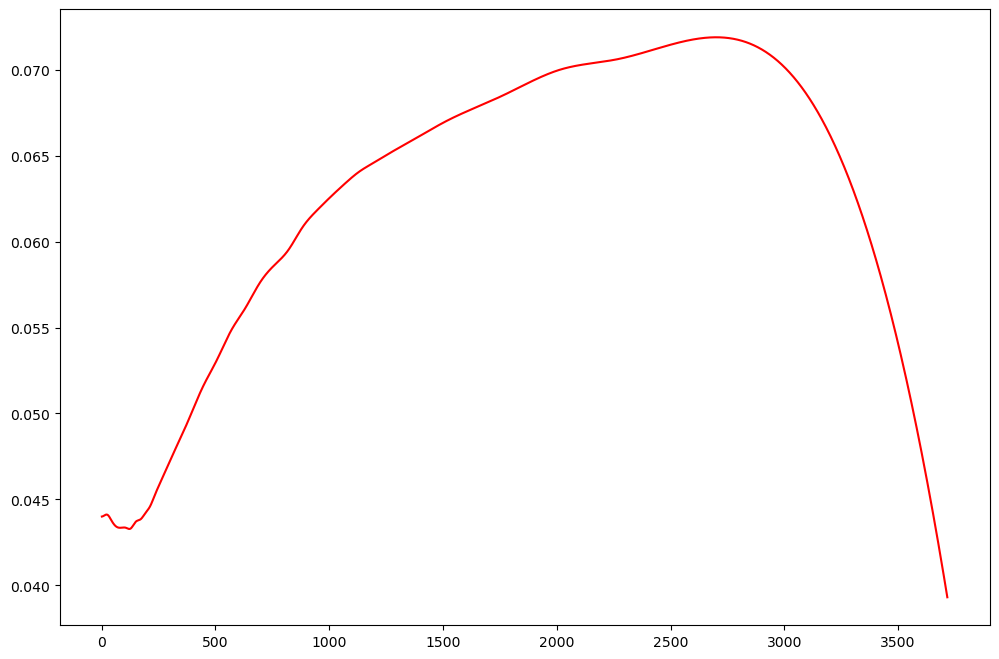

In [180]:
int_plot = df_yield_curve_int.iloc[941]
cs = plt.figure(figsize = (12,8))
plt.plot(int_plot, color = 'r')
cs.savefig("./cubicspline.png")

In [224]:
int_plot.head(10)

In [184]:
df_yield_curve.head(5)

DU,0,1,2,3,4,5,6,7,8,9,...,3671,3676,3681,3686,3691,3696,3701,3706,3711,3716
refdate,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,0.157300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,0.156901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-16,NaN,0.155899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-23,NaN,0.151500,NaN,NaN,NaN,NaN,NaN,0.152299,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-30,NaN,0.150801,0.150202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Assuming an average of 20 working days a month to get a good comparison with the Custo Médio da Dívida Mobiliária 

In [221]:
dates = df_yield_curve.iloc[:, 0]
di_int = int_plot.values 

di_int

array([       nan, 0.04400116, 0.04400281, ..., 0.04011494, 0.03971085,
       0.03930345])

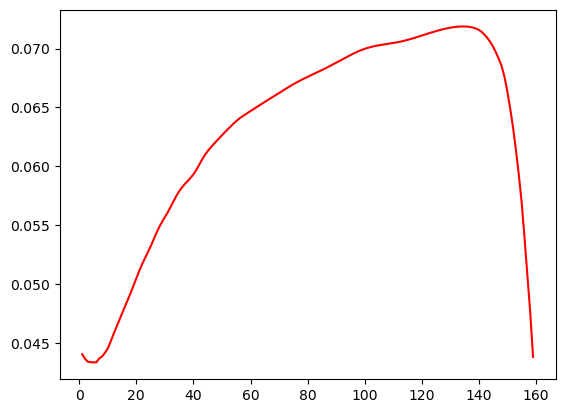

In [223]:
mbd = 20
num_groups = len(di_int) // mbd

averages_group = []

for i in range(num_groups):
    start = i * mbd
    end = (i + 1) * mbd
    averages = np.mean(di_int[start:end])
    averages_group.append(averages)

averages_array = np.array(averages_group)

plt.plot(averages_array, color = 'r')

In [174]:
##compare with custo médio da dívida mobiliária
cmdm = pd.read_excel("/Users/thaispalanca/Desktop/project macro/cmdm.xlsx")
cmdm

,data,r1,r
0,2002-01-01,23.864089,0.238641
1,2002-01-02,12.342594,0.123426
2,2002-01-03,14.926566,0.149266
3,2002-01-04,19.023469,0.190235
4,2002-01-05,29.306754,0.293068
...,...,...,...
211,2019-01-08,8.806056,0.088061
212,2019-01-09,7.327584,0.073276
213,2019-01-10,6.416126,0.064161
214,2019-01-11,7.963730,0.079637


In [214]:
cm =cmdm[:160]

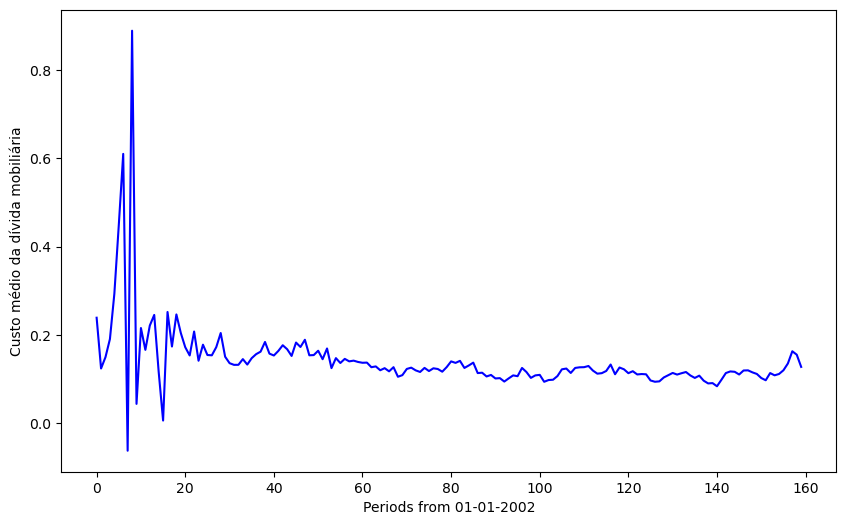

In [218]:
cmdmfig = plt.figure(figsize=(10, 6))
plt.plot(cm['r'], color = 'b')
plt.xlabel(r'Periods from 01-01-2002')
plt.ylabel(r'Custo médio da dívida mobiliária')
cmdmfig.savefig("./cmdm.png")

In [235]:
intplot_subset = int_plot.iloc[1:219]

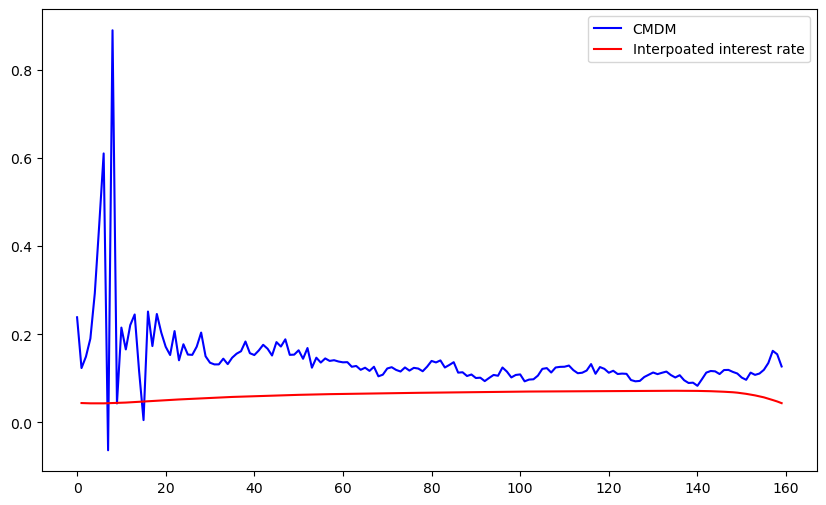

In [227]:
com = plt.figure(figsize=(10, 6))
plt.plot(cm['r'], label='CMDM', linestyle='-', color='blue')
plt.plot(medias_array, label='Interpoated interest rate', linestyle='-', color='red')
plt.legend()
com.savefig("./comp.png")

In [238]:
##making ettj quarterly for next exercise

# Calcule a média a cada 3 observações
quarterly = intplot_subset.groupby(intplot_subset.index // 3).mean()

# Exiba o resultado
print(quarterly)

quarterly.to_excel('/Users/thaispalanca/Desktop/project macro/ettj.xlsx', index=False)

DU
0     0.044002
1     0.044010
2     0.044028
3     0.044051
4     0.044075
        ...   
68    0.044427
69    0.044486
70    0.044552
71    0.044626
72    0.044709
Name: 2019-12-26, Length: 73, dtype: float64
